Буховец Ольга

ab_test_results_aggregated_views_clicks_6.csv.zip

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro
import os
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

In [3]:
ab = pd.read_csv('ab_test_results_aggregated_views_clicks_6.csv.zip')

In [4]:
ab.head ()

,user_id,group,views,clicks
0,1,control,3.0000,0.0000
1,2,control,1.0000,0.0000
2,3,control,3.0000,1.0000
3,4,control,5.0000,0.0000
4,5,control,2.0000,0.0000


In [5]:
ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  80000 non-null  int64  
 1   group    80000 non-null  object 
 2   views    80000 non-null  float64
 3   clicks   80000 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.1+ MB


In [6]:
# посмотрим количество уникальных значений
ab.nunique()

user_id    80000
group          2
views        101
clicks        18
dtype: int64

In [7]:
ab.group.unique()

array(['control', 'test'], dtype=object)

In [8]:
ab['ctr']=ab.clicks/ab.views*100

In [9]:
ab

,user_id,group,views,clicks,ctr
0,1,control,3.0000,0.0000,0.0000
1,2,control,1.0000,0.0000,0.0000
2,3,control,3.0000,1.0000,33.3333
3,4,control,5.0000,0.0000,0.0000
4,5,control,2.0000,0.0000,0.0000
...,...,...,...,...,...
79995,79996,test,4.0000,0.0000,0.0000
79996,79997,test,2.0000,0.0000,0.0000
79997,79998,test,13.0000,1.0000,7.6923
79998,79999,test,2.0000,0.0000,0.0000


In [10]:
ab.ctr.describe ()

count   80000.0000
mean        7.4765
std        16.6210
min         0.0000
25%         0.0000
50%         0.0000
75%         7.6923
max       100.0000
Name: ctr, dtype: float64

In [11]:
ab.isna().sum()

user_id    0
group      0
views      0
clicks     0
ctr        0
dtype: int64

In [12]:
ab.ctr.value_counts ()

0.0000     57979
33.3333     2857
50.0000     2706
25.0000     2370
20.0000     1991
           ...  
55.5556        1
10.1449        1
19.4444        1
1.9608         1
7.2464         1
Name: ctr, Length: 242, dtype: int64

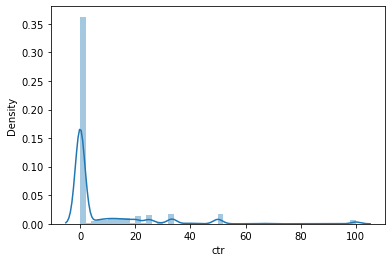

In [13]:
sns_plot = sns.distplot(ab['ctr'])
fig = sns_plot.get_figure()

In [14]:
ab.sort_values(by='ctr', ascending = False).iloc[:15]

,user_id,group,views,clicks,ctr
51201,51202,test,1.0000,1.0000,100.0000
54752,54753,test,1.0000,1.0000,100.0000
73575,73576,test,2.0000,2.0000,100.0000
65075,65076,test,1.0000,1.0000,100.0000
37435,37436,control,1.0000,1.0000,100.0000
25397,25398,control,1.0000,1.0000,100.0000
20240,20241,control,1.0000,1.0000,100.0000
6291,6292,control,1.0000,1.0000,100.0000
22846,22847,control,1.0000,1.0000,100.0000
59390,59391,test,1.0000,1.0000,100.0000


In [15]:
all_stat = ab.groupby(by = 'group').agg({'user_id': 'nunique', 'ctr': ['mean', 'median', 'count']})
all_stat

user_id    ctr              
        nunique   mean median  count
group                               
control   40000 6.9166 0.0000  40000
test      40000 8.0363 0.0000  40000

# Т.к. распределение не нормальное, то используем тест Манна-Уитни

In [16]:
mannwhitneyu(ab.loc[ab.group == 'control', 'ctr'], ab.loc[ab.group == 'test', 'ctr'])

MannwhitneyuResult(statistic=772911297.0, pvalue=1.0938834046391723e-16)

# Вывод: Различия в группах есть. Принимаем альтернативную гипотезу. Тестируемые изменения привели к изменеию значения ctr

# Метод Бутстрэп

In [17]:
# Данная функция написана организацией, которая занимается A/B тестированием
# Ее мы можем применять для своего анализа, корректируя под свои данные

# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    column_1, # числовые значения первой выборки
    column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(column_1), len(column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [18]:
ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  80000 non-null  int64  
 1   group    80000 non-null  object 
 2   views    80000 non-null  float64
 3   clicks   80000 non-null  float64
 4   ctr      80000 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.7+ MB


In [19]:
ab_test = ab.query("group =='test'")
ab_control = ab.query("group =='control'")

In [20]:
column_1 = ab_test['ctr']
column_2 = ab_control['ctr']

  0%|          | 0/2000 [00:00<?, ?it/s]

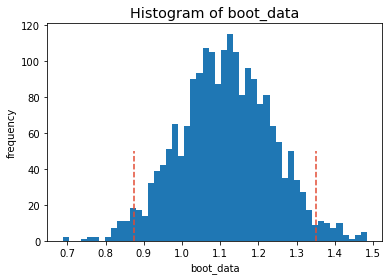

In [21]:
booted_data = get_bootstrap(column_1, column_2, boot_it = 2000)

# Вывод: т.к. ноль не попадает в доверительный интервал, то H0 отклоняется и принимается альтернативная гипотеза. На заданном уровне значимости различия между группами есть.